In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder  

In [2]:
try:
    df = pd.read_json('problems_data.jsonl', lines=True)
except ValueError:
    print("Error: check filetype again")
    exit()

In [3]:
df = df.dropna(subset=['problem_score', 'problem_class'])
le = LabelEncoder()
df['difficulty_label'] = le.fit_transform(df['problem_class'])
class_mapping = {k: int(v) for k, v in zip(le.classes_, le.transform(le.classes_))} #int(v) so int64 doesn't come
print("Mapping:", class_mapping) #yo remember hard is 1
text_columns = ['title', 'description', 'input_description', 'output_description']
for col in text_columns:
    df[col] = df[col].fillna('')

df['combined_text'] = (
    df['title'] + " " + 
    df['description'] + " " + 
    df['input_description'] + " " + 
    df['output_description']
)

def upd(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = " ".join(text.split())
    return text

df['combined_text'] = df['combined_text'].apply(upd)

Mapping: {'easy': 0, 'hard': 1, 'medium': 2}


In [6]:
hard_topics = [
    'convex hull', 'mobius', 'segment tree', 'flow', 'centroid', 
    'geometry', 'gcd', 'subarray', 'mex', 'dynamic programming', 
    'modulo', 'bitwise', 'graph', 'expected value','permutations','xor'
]
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    col_name = f'has_{topic.replace(" ", "_")}'
    df[col_name] = df['combined_text'].str.contains(topic, case=False).astype(int)  

df['hard_topic_count'] = 0
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    df['hard_topic_count'] += df['combined_text'].str.contains(topic, case=False).astype(int)
    
                                                                            
df['is_short_statement'] = (df['combined_text'].str.len() < 300).astype(int)
df['text_len'] = df['combined_text'].apply(len)
df['has_high_constraints'] = df['combined_text'].str.contains(r'10\^5|10\^9|1000000007|1e9|1e5', regex=True).astype(int)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',   #ignoring common words like problem
    ngram_range=(1, 2), 
    max_features=5000
)
X_tfidf = tfidf.fit_transform(df['combined_text'])

#print("Dim", X_tfidf.shape)
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(), 
    columns=tfidf.get_feature_names_out()
)
updlist = [
    'text_len', 'math_count', 'hard_topic_count', 'has_high_constraints','is_short_statement'
] + [f'has_{topic.replace(" ", "_")}' for topic in hard_topics]

upddf = df[updlist].reset_index(drop=True)
Xf = pd.concat([tfidf_df, upddf], axis=1)

print(f" Fin Count {Xf.shape[1]}.")


 Fin Count 5021.


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Xf, 
    df['difficulty_label'], 
    test_size=0.28, 
    random_state=7,   #rerun doesn't changes it
    stratify=df['difficulty_label']  #maintain a good ratio
)

print(f" on {X_train.shape[0]} problems...")

 on 2960 problems...


Model Accuracy: 0.51


              precision    recall  f1-score   support

        easy       0.63      0.27      0.38       214
        hard       0.53      0.84      0.65       544
      medium       0.33      0.17      0.22       394

    accuracy                           0.51      1152
   macro avg       0.50      0.43      0.42      1152
weighted avg       0.48      0.51      0.45      1152



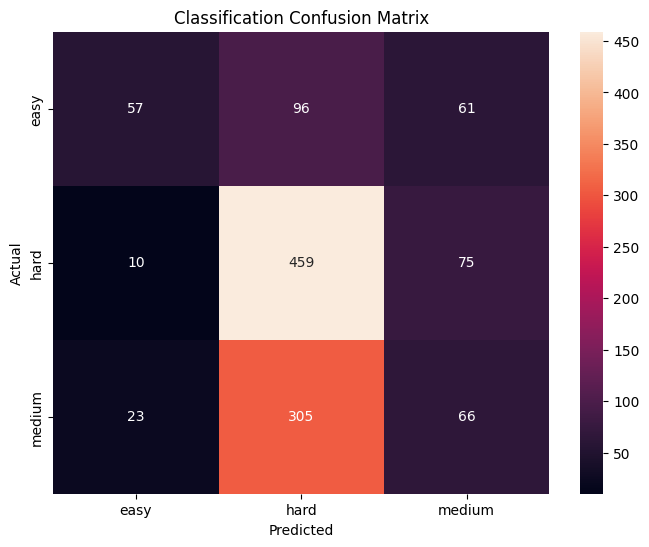

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Confusion Matrix')
plt.show()
